In [81]:
import os
import json
import re
import scipy.io as spio
import numpy as np
from bokeh.plotting import figure
import tifffile as tf
import seaborn as sns
# %matplotlib notebook
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import skimage.color
from json_tricks.np import dump, dumps, load, loads
from mat2py import loadmat
from skimage import color
import cPickle as pkl

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [82]:
# import optparse

# parser = optparse.OptionParser()
# parser.add_option('-S', '--source', action='store', dest='source', default='/nas/volume1/2photon/projects', help='source dir (root project dir containing all expts) [default: /nas/volume1/2photon/projects]')
# parser.add_option('-E', '--experiment', action='store', dest='experiment', default='', help='experiment type (parent of session dir)') 
# parser.add_option('-s', '--session', action='store', dest='session', default='', help='session dir (format: YYYMMDD_ANIMALID') 
# parser.add_option('-A', '--acq', action='store', dest='acquisition', default='', help="acquisition folder (ex: 'FOV1_zoom3x')")
# parser.add_option('-f', '--functional', action='store', dest='functional_dir', default='functional', help="folder containing functional TIFFs. [default: 'functional']")

# parser.add_option('-O', '--stimon', action="store",
#                   dest="stim_on_sec", default='', help="Time (s) stimulus ON.")
# parser.add_option('-i', '--iti', action="store",
#                   dest="iti_pre", default=1., help="Time (s) before stim onset to use as basline [default=1].")
# parser.add_option('-z', '--slice', action="store",
#                   dest="sliceidx", default=0, help="Slice index to look at (0-index) [default: 0]")

# parser.add_option('--custom', action="store_true",
#                   dest="custom_mw", default=False, help="Not using MW (custom params must be specified)")
# parser.add_option('-g', '--gap', action="store",
#                   dest="gap", default=400, help="num frames to separate subplots [default: 400]")

# (options, args) = parser.parse_args() 


# source = options.source #'/nas/volume1/2photon/projects'
# experiment = options.experiment #'scenes' #'gratings_phaseMod' #'retino_bar' #'gratings_phaseMod'
# session = options.session #'20171003_JW016' #'20170927_CE059' #'20170902_CE054' #'20170825_CE055'
# acquisition = options.acquisition #'FOV1' #'FOV1_zoom3x' #'FOV1_zoom3x_run2' #'FOV1_planar'
# functional_dir = options.functional_dir #'functional' #'functional_subset'

# stim_on_sec = float(options.stim_on_sec) #2. # 0.5
# iti_pre = float(options.iti_pre)

# custom_mw = options.custom_mw
# spacing = int(options.gap)
# curr_slice_idx = options.sliceidx

In [83]:
source = '/nas/volume1/2photon/projects'
experiment = 'gratings_phaseMod'
session = '20171009_CE059'
acquisition = 'FOV1_zoom3x'
functional_dir = 'functional'

curr_file_idx = 6
curr_slice_idx = 0 #1 #20
custom_mw = False

# source = '/nas/volume1/2photon/projects'
# experiment = 'scenes'
# session = '20171003_JW016'
# acquisition = 'FOV1'
# functional_dir = 'functional'
# 
# curr_file_idx = 2
# curr_slice_idx = 20
curr_roi_method = 'blobs_DoG'
plot_traces = True #False


In [84]:
acquisition_dir = os.path.join(source, experiment, session, acquisition)
figdir = os.path.join(acquisition_dir, 'example_figures')

# Create ROI dir in figures:
figbase = 'example_figures'
figdir = os.path.join(acquisition_dir, figbase, 'rois')
if not os.path.exists(figdir):
    os.mkdirs(figdir)
    
# Load reference info:
ref_json = 'reference_%s.json' % functional_dir 
with open(os.path.join(acquisition_dir, ref_json), 'r') as fr:
    ref = json.load(fr)
    
# Load SI meta data:
si_basepath = ref['raw_simeta_path'][0:-4]
simeta_json_path = '%s.json' % si_basepath
with open(simeta_json_path, 'r') as fs:
    simeta = json.load(fs)


In [85]:
# Get masks for each slice: 
roi_methods_dir = os.path.join(acquisition_dir, 'ROIs')
roiparams = loadmat(os.path.join(roi_methods_dir, curr_roi_method, 'roiparams.mat'))
maskpaths = roiparams['roiparams']['maskpaths']
if not isinstance(maskpaths, list):
    maskpaths = [maskpaths]

masks = dict(("Slice%02d" % int(slice_idx+1), dict()) for slice_idx in range(len(maskpaths)))
for slice_idx,maskpath in enumerate(sorted(maskpaths, key=natural_keys)):
    slice_name = "Slice%02d" % int(slice_idx+1)
    print "Loading masks: %s..." % slice_name 
    currmasks = loadmat(maskpath); currmasks = currmasks['masks']
    masks[slice_name]['nrois'] =  currmasks.shape[2]
    masks[slice_name]['masks'] = currmasks

slice_names = sorted(masks.keys(), key=natural_keys)
print "SLICE NAMES:", slice_names
curr_slice_name = slice_names[curr_slice_idx]


Loading masks: Slice01...
SLICE NAMES: ['Slice01']


In [86]:
# # Get FILE list:
# average_source = 'Averaged_Slices_Corrected'
# signal_channel = 1
# average_slice_dir = os.path.join(acquisition_dir, functional_dir, 'DATA', average_source, "Channel{:02d}".format(signal_channel))
# file_names = [f for f in os.listdir(average_slice_dir) if '_vis' not in f]
# print "File names:", file_names
# nfiles = len(file_names)

In [87]:
# Get PARADIGM INFO:
path_to_functional = os.path.join(acquisition_dir, functional_dir)
paradigm_dir = 'paradigm_files'
path_to_paradigm_files = os.path.join(path_to_functional, paradigm_dir)
path_to_trace_structs = os.path.join(acquisition_dir, 'Traces', curr_roi_method, 'Parsed')

### LOad trial info dict:
with open(os.path.join(path_to_paradigm_files, 'parsed_trials.pkl'), 'rb') as f:
    trialdict = pkl.load(f)
trialdict.keys()

['File001',
 'File003',
 'File002',
 'File005',
 'File004',
 'File007',
 'File006',
 'File009',
 'File008',
 'File010']

In [88]:
# Load stim trace structs:
print "Loading parsed traces..."
stimtrace_fns = os.listdir(path_to_trace_structs)
stimtrace_fns = sorted([f for f in stimtrace_fns if 'stimtraces' in f and f.endswith('.pkl')], key=natural_keys)
stimtrace_fn = stimtrace_fns[curr_slice_idx]
with open(os.path.join(path_to_trace_structs, stimtrace_fn), 'rb') as f:
    stimtraces = pkl.load(f)

Loading parsed traces...


In [89]:
stimlist = sorted(stimtraces.keys(), key=natural_keys)
nstimuli = len(stimlist)
nrois = stimtraces[stimlist[0]]['nrois']

In [90]:
currfile='File001'
stim_on_sec = 2.
iti = 1. #4.
nframes = int(simeta[currfile]['SI']['hFastZ']['numVolumes'])
framerate = float(simeta[currfile]['SI']['hRoiManager']['scanFrameRate'])
volumerate = float(simeta[currfile]['SI']['hRoiManager']['scanVolumeRate'])
frames_tsecs = np.arange(0, nframes)*(1/volumerate)

nframes_on = stim_on_sec * volumerate
#nframes_off = vols_per_trial - nframes_on
frames_iti = round(iti * volumerate) 
print nframes_on
print frames_iti

89.4054
45.0


In [91]:

color_by_roi = True

spacing = 25
cmaptype = 'rainbow'
colormap = plt.get_cmap(cmaptype)

if color_by_roi:
    colorvals = colormap(np.linspace(0, 1, nrois)) #get_spaced_colors(nrois)
else:
    colorvals = colormap(np.linspace(0, 1, nstimuli)) #get_spaced_colors(nstimuli)

colorvals255 = [c[0:-1]*255 for c in colorvals]
#colorvals = np.true_divide(colorvals255, 255.)
#print len(colorvals255)
roi_interval = 10

#plot_rois = np.arange(0, nrois, roi_interval) #int(nrois/2)
plot_rois = [1]

In [92]:
stimlist
stimnames = [stimtraces[stim]['name'] for stim in stimlist]
stimnames

[u'grating-ori-0-sf-0.100000',
 u'grating-ori-0-sf-0.500000',
 u'grating-ori-30-sf-0.100000',
 u'grating-ori-30-sf-0.500000',
 u'grating-ori-60-sf-0.100000',
 u'grating-ori-60-sf-0.500000',
 u'grating-ori-90-sf-0.100000',
 u'grating-ori-90-sf-0.500000',
 u'grating-ori-120-sf-0.100000',
 u'grating-ori-120-sf-0.500000',
 u'grating-ori-150-sf-0.100000',
 u'grating-ori-150-sf-0.500000']

In [93]:
stiminfo = dict()
print "STIM | ori - sf"
for stim in stimlist: #sorted(stimtraces.keys(), key=natural_keys):
    
    ori = stimtraces[stim]['name'].split('-')[2]
    sf = stimtraces[stim]['name'].split('-')[4]
    stiminfo[stim] = (int(ori), float(sf))
    print stim, ori, sf

STIM | ori - sf
1 0 0.100000
2 0 0.500000
3 30 0.100000
4 30 0.500000
5 60 0.100000
6 60 0.500000
7 90 0.100000
8 90 0.500000
9 120 0.100000
10 120 0.500000
11 150 0.100000
12 150 0.500000


In [107]:
oris = sorted(list(set([stiminfo[stim][0] for stim in stimlist])))
sfs = sorted(list(set([stiminfo[stim][1] for stim in stimlist])))
noris = len(set(oris))
nsfs = len(set(sfs))

In [108]:
stiminfo

{'1': (0, 0.1),
 '10': (120, 0.5),
 '11': (150, 0.1),
 '12': (150, 0.5),
 '2': (0, 0.5),
 '3': (30, 0.1),
 '4': (30, 0.5),
 '5': (60, 0.1),
 '6': (60, 0.5),
 '7': (90, 0.1),
 '8': (90, 0.5),
 '9': (120, 0.1)}

[0]
[ 6  7  8  9 10 11]


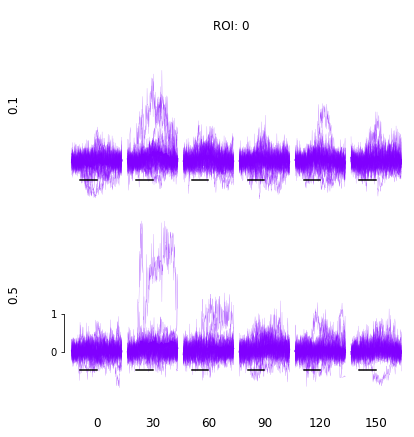

In [109]:
print plot_rois
plot_rois = [0]


even_idxs = np.arange(noris, noris*2)
print even_idxs
for ridx, roi in enumerate(plot_rois):

    fig = plt.figure(figsize=(noris, noris))
    gs = gridspec.GridSpec(nsfs, noris)
    gs.update(wspace=.01, hspace=.01)
    
    rowidx= 0
    plotidx = 0
    for stimidx, stim in enumerate(stimlist):
    #for sf in range(nsfs):
        ori = stiminfo[stim][0]
        sf = stiminfo[stim][1]
        

        if np.mod(stimidx,2)==0:
            plt.subplot(gs[stimidx/2])
            bottomrow = False
        else: 
            plt.subplot(gs[even_idxs[rowidx]])
            bottomrow = True
            rowidx += 1
            
        ntrialstmp = len(stimtraces[stim]['traces'])
        nframestmp = min([stimtraces[stim]['traces'][i].shape[0] for i in range(len(stimtraces[stim]['traces']))])
        raw = np.zeros((ntrialstmp, nframestmp))
        for trialnum in range(ntrialstmp):
            raw[trialnum, :] = stimtraces[stim]['traces'][trialnum][0:nframestmp, roi].T

        xvals = np.arange(0, raw.shape[1])

        ntrials = raw.shape[0]
        nframes_in_trial = raw.shape[1]
        curr_dfs = np.empty((ntrials, nframes_in_trial))
        for trial in range(ntrials):
            if custom_mw is True:
                frame_on = stimtraces[stim]['frames_stim_on'][trial][0]
            else:
                #frame_on = int(frames_iti)+1 #stimtraces[stim]['frames_stim_on'][trial][0]
                frame_on = stimtraces[stim]['frames'][trial].index(stimtraces[stim]['frames_stim_on'][trial][0])

            baseline = np.mean(raw[trial, 0:frame_on])
            df = (raw[trial,:] - baseline) / baseline
            curr_dfs[trial,:] = df

            if color_by_roi:
                plt.plot(xvals, df, color=colorvals[roi], alpha=.7, linewidth=0.2)
            else:
                plt.plot(xvals, df, color=colorvals[stimnum], alpha=1, linewidth=0.2)

        # Plot stimulus ON period:
        if custom_mw is True:
            stim_frames = xvals[0] + stimtraces[stim]['frames_stim_on'][trial] #frames_stim_on[stim][trial]
        else:
            on_fr_idx = stimtraces[stim]['frames'][trial].index(stimtraces[stim]['frames_stim_on'][trial][0])
            nframes_on = (stimtraces[stim]['frames_stim_on'][trial][1] - stimtraces[stim]['frames_stim_on'][trial][0] + 1)
            off_fr_idx = on_fr_idx + nframes_on - 1
            stim_frames = [on_fr_idx, off_fr_idx]

        plt.plot(stim_frames, np.ones((2,))*-0.5, color='k')
        plt.ylim([-1, 4])
        
        # Plot average:
        avg = np.mean(curr_dfs, axis=0) 
        if color_by_roi:
            plt.plot(xvals, avg, color=colorvals[roi], alpha=1, linewidth=1.2)
        else:
            plt.plot(xvals, avg, color=colorvals[stimnum], alpha=1, linewidth=1.2)

        # Format subplots:
        if plotidx==0:
            plt.axis('off')
            ax = plt.gca()
            ax.text(-1,0.5, sfs[0], size=12, ha="center", rotation=90, transform=ax.transAxes)
        elif plotidx==nsfs-1:
            plt.yticks([0, 1])
            sns.despine(bottom=True, trim=True, offset=5)
            ax = plt.gca()
            ax.text(-1,0.5, sfs[1], size=12, ha="center", rotation=90, transform=ax.transAxes)
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_xaxis().set_ticks([])
        else:
            plt.axis('off')
        
        if bottomrow is True:
            ax = plt.gca()
            ax.text(.5,-0.2, oris[rowidx-1], size=12, ha="center", rotation=0, transform=ax.transAxes)
           
        ptitle = "%2.0f., %0.2f" % (float(stiminfo[stim][0]), float(stiminfo[stim][1]))

        plotidx += 1

    plt.subplots_adjust(top=1)
    plt.suptitle('ROI: %i' % ridx)
    
    figname = 'stimgrid_roi%i.png' % int(ridx+1)
    #plt.savefig(os.path.join(figdir, figname), bbox_inches='tight', pad=0)

    plt.show()